In [1]:
import torch
import phate
import scprep
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import os
import sys
import math

In [2]:
#Obtain tree data
#default params nbranch=5, branch_length=100
tree_data, tree_clusters = phate.tree.gen_dla(n_dim=10, n_branch=10, branch_length=200)

In [3]:
#Define phate operator
phate_operator = phate.PHATE(random_state=42)
tree_phate = phate_operator.fit_transform(tree_data)
P = phate_operator.diff_potential

Calculating PHATE...
  Running PHATE on 2000 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
    Calculated affinities in 0.36 seconds.
  Calculated graph and diffusion operator in 0.43 seconds.
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 1.42 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.47 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.80 seconds.
Calculated PHATE in 7.15 seconds.


(2000, 10)
(2000, 2)
(2000,)


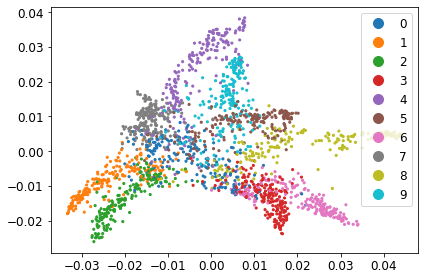

In [4]:
#PHATE plot of original data
cax = scprep.plot.scatter2d(tree_phate, c=tree_clusters)
print(tree_data.shape)
print(tree_phate.shape)
print(tree_clusters.shape)

In [5]:
#Store data in tensor

X = torch.tensor(tree_data, requires_grad=True)
Pcuda = torch.tensor(P,requires_grad=True)
n = tree_data.shape[0]
random_indices = np.random.randint(n, size=n)

In [6]:
#Define phate function


def torch_phate(X, kernel="gaussian", bandwidth=1000, t=10):
    dists = torch.norm(X[:, None] - X, dim=2, p="fro")

    def gaussian_kernel(x):
        return torch.exp(-(dists**2) / bandwidth)

    kernel = gaussian_kernel(dists)
    p = kernel / kernel.sum(axis=0)[:, None]
    pt = torch.matrix_power(p, t)
    log_p = torch.log(pt)
    return pt



In [7]:
print(Pcuda.shape)
print(X.shape)

torch.Size([2000, 2000])
torch.Size([2000, 10])


With the Autoencoder

In [6]:
#Define Autoencoder class

import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(
        self,
        encoder_layer=[10, 10, 10],
        decoder_layer=[10, 10, 10],
        activation="ReLU",
        use_cuda=False,
    ) -> None:
        super().__init__()
        device = "cuda" if use_cuda else "cpu"
        
        c = 0
        encoder = []
        for i0, i1 in zip(encoder_layer, encoder_layer[1:]):
            c = c + 1
            encoder.append(nn.Linear(i0, i1))
            if c == 1:
                encoder.append(getattr(nn, "ReLU")())
            #else:
            #    encoder.append(getattr(nn, "ReLU")())
            
        print("Encoder",encoder)
        self.encoder = nn.Sequential(*encoder).to(device)
        
        c = 0
        decoder=[]
        for i0,i1 in zip(decoder_layer,decoder_layer[1:]):
            c = c + 1
            decoder.append(nn.Linear(i0, i1))
            if c == 1:
                decoder.append(getattr(nn,"ReLU")())
        print("Decoder",decoder)
        self.decoder = nn.Sequential(*decoder).to(device)
        
    

    def encode(self,x):
        x = self.encoder()
        return x

    def decode(self,x):
        x = self.decoder(x)
        return x

In [16]:
##### Define Model Characteristics

use_cuda = torch.cuda.is_available()
phate_ae = Autoencoder(
    encoder_layer=[10, 10, 2], decoder_layer=[2, 10, 10], use_cuda=use_cuda)


optimizer = torch.optim.AdamW(phate_ae.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.05)

n_epochs = 300
n_train = int(n*0.6)

#Get random train indices
fullind = np.arange(tree_data.shape[0])
random_indices = np.random.choice(
    fullind, size=n_train, replace=False
)  

#Define batch size
batch_size = 64
n_batches = int(n_train/batch_size)

train_loss_a = []
for epoch in range(n_epochs):

    
    #zero gradients
    optimizer.zero_grad()
    
    #shuffle indices
    np.random.shuffle(random_indices)
    phate_operator = phate.PHATE(random_state=42,verbose=0)
    X_sample = phate_operator.fit_transform(tree_data[random_indices])
    P = phate_operator.diff_potential
    
    X_sample = torch.tensor(tree_data,requires_grad=True)
    P = torch.tensor(P,requires_grad=True)
    
    #add noise
    noise = (
        (torch.randn(X_sample.size())).cuda()
        if use_cuda
        else torch.randn(X_sample.size())
    )  # define noise from Gaussian distribution
    
    
    for i in range(n_batches):
        

        xbatch = X_sample[i*batch_size:(i*batch_size)+batch_size].detach().float() #get batch for samples
        pbatch = P[i*batch_size:(i*batch_size)+batch_size].cuda().detach().float() #get batch for phate embedding
        nbatch = noise[i*batch_size:(i*batch_size)+batch_size].detach().float() #get batch for noise
        
        xbatch.requires_grad = True
        pbatch.requires_grad = True
        nbatch.requires_grad = True
        
  
        encode_sample = phate_ae.encoder(
           xbatch.cuda() + nbatch.cuda()
        )  # encode phate into 2 dimensions

        geom_loss = nn.MSELoss()(
            torch.cdist(encode_sample, encode_sample), torch.cdist(pbatch, pbatch)
        )  # Loss between encoded space and phate potential distance


        decode_sample = phate_ae.decode(encode_sample)  # decode embedding
        recon_loss = nn.MSELoss()(decode_sample,xbatch.cuda())  # Loss decoded embedding and original
     
        if epoch < 10000:
            loss = recon_loss + (0.005*(geom_loss))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            scheduler.step()
            loss = recon_loss + (geom_loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    train_loss_a.append(loss)
    
    

    if epoch % 10 == 0:
        #print(recon_loss)
        #print(geom_loss)
        print("Recon Loss:", recon_loss)
        print("Gemetric Loss:", (0.005*geom_loss))
        print("Total Loss:", loss)

        

Encoder [Linear(in_features=10, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=2, bias=True)]
Decoder [Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True)]
Recon Loss: tensor(101.4902, device='cuda:0', grad_fn=<MseLossBackward0>)
Gemetric Loss: tensor(37.2342, device='cuda:0', grad_fn=<MulBackward0>)
Total Loss: tensor(138.7243, device='cuda:0', grad_fn=<AddBackward0>)
Recon Loss: tensor(51.5410, device='cuda:0', grad_fn=<MseLossBackward0>)
Gemetric Loss: tensor(39.8703, device='cuda:0', grad_fn=<MulBackward0>)
Total Loss: tensor(91.4113, device='cuda:0', grad_fn=<AddBackward0>)
Recon Loss: tensor(41.2465, device='cuda:0', grad_fn=<MseLossBackward0>)
Gemetric Loss: tensor(37.9818, device='cuda:0', grad_fn=<MulBackward0>)
Total Loss: tensor(79.2283, device='cuda:0', grad_fn=<AddBackward0>)
Recon Loss: tensor(40.1578, device='cuda:0', grad_fn=<MseLossBackward0>)
Gemetric Loss: tensor(28.0856, device='cuda

Text(0.5, 0, 'Number of epochs')

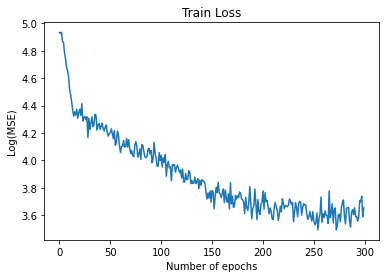

In [17]:
#Plot train loss
ctrain = torch.stack(train_loss_a).detach().cpu().numpy()

plt.title("Train Loss")
plt.plot(np.log(ctrain))
plt.ylabel("Log(MSE)")
plt.xlabel("Number of epochs")

/tmp/ipykernel_5623/3764423988.py:43: RuntimeWarning: overflow encountered in exp
  prod[i,j] = np.sum(AJacob[k,:,i] * AJacob[k,:,j] * np.exp(xsampout[k,:]))
/tmp/ipykernel_5623/3764423988.py:43: RuntimeWarning: overflow encountered in multiply
  prod[i,j] = np.sum(AJacob[k,:,i] * AJacob[k,:,j] * np.exp(xsampout[k,:]))


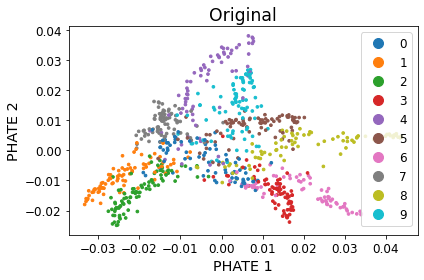

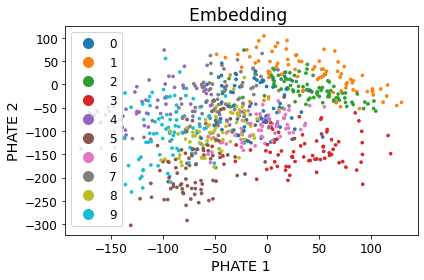

In [18]:
# Get test indices
testind = []
fullind = list(np.arange(tree_data.shape[0]))
for i in fullind:
    if i not in random_indices:
        testind.append(i)
testind = np.array(testind)

# Get samples from autoencoder
nxsample = phate_ae.encoder(X[testind].float().cuda())
xsampout = nxsample.detach().cpu().numpy()
clustlab = tree_clusters[testind]
origsamp = tree_phate[testind]

# Visualize ground truth (Test data points)
cax = scprep.plot.scatter2d(
    origsamp,
    c=clustlab,
    title="Original",
    xlabel="PHATE 1",
    ylabel="PHATE 2",
)

# Visualize Embedding
cax = scprep.plot.scatter2d(xsampout, c=clustlab, title="Embedding ",xlabel="PHATE 1",ylabel="PHATE 2")

# Compute Jacobian
Jacob = []
for i in testind:
    X_sample = X[i].float().cuda()
    J = torch.autograd.functional.jacobian(phate_ae.encoder, X_sample).squeeze()
    Jacob.append(J.cpu().detach().numpy())
AJacob = np.array(Jacob)


prod = np.empty((X.shape[1],X.shape[1]))
#Compute FIM
FIM = []
for k in range(xsampout.shape[0]):
    prod = np.empty((X.shape[1],X.shape[1]))
    for i in range(AJacob.shape[2]):
        for j in range(AJacob.shape[2]):
            prod[i,j] = np.sum(AJacob[k,:,i] * AJacob[k,:,j] * np.exp(xsampout[k,:]))

    FIM.append(prod)



    


720


/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


'\nV = np.expand_dims(V[vsortind],axis=1) #Expand for concatenation\nVtree = np.concatenate((tree_phate[testind[sortind]],V),axis=1)\nnp.save("Vtree_t_tten_sigone.npy",Vtree)'

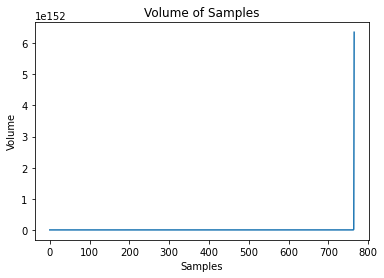

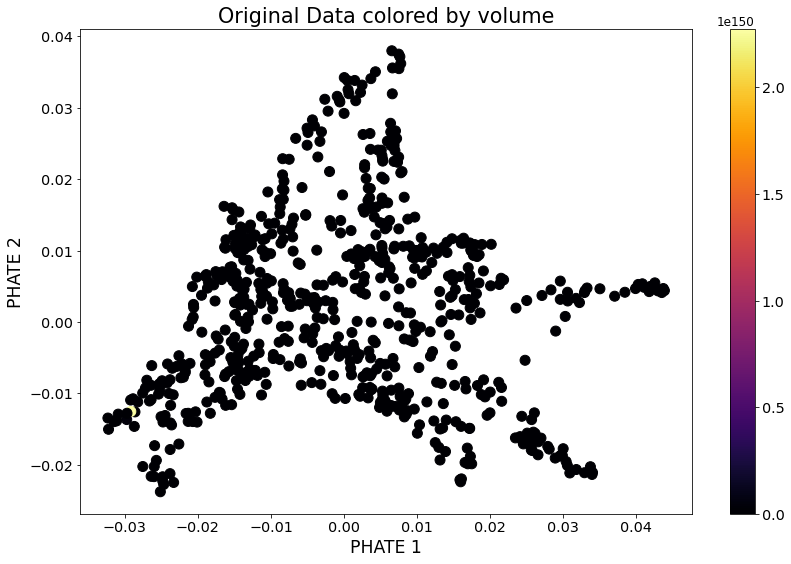

In [28]:
# Analysis/Data Visualization

#Compute Volume
V = np.sqrt(np.abs(np.linalg.det(np.array(FIM))))

#Plot
plt.plot(np.sort(V))
plt.title("Volume of Samples")
plt.ylabel("Volume")
plt.xlabel("Samples")

#Remove outliers (Take all points within two standard deviations [95%])
vsortind = np.argsort(np.abs(V - np.median(V)))[:int(0.90*len(V))]
print(len(vsortind))

# Visualize Volume on original embedding
cax = scprep.plot.scatter2d(
    origsamp[vsortind],
    c = V[vsortind],
    title="Original Data colored by volume",
    fontsize=12,
    xlabel="PHATE 1",
    ylabel="PHATE 2",
    figsize = (12,8),
    s = 100
)

"""
V = np.expand_dims(V[vsortind],axis=1) #Expand for concatenation
Vtree = np.concatenate((tree_phate[testind[sortind]],V),axis=1)
np.save("Vtree_t_tten_sigone.npy",Vtree)"""


In [29]:
#Eigendecompose FIM

Emaxval = []
Evecone = []
Evectwo = []
Eigind = []
trace = []


for i in range(len(FIM)):
    
    #check for nan's or ints
    if math.isnan(np.linalg.det(FIM[i])) or math.isinf(np.linalg.det(FIM[i])): 
        continue
        
    eigval, eigvec = np.linalg.eig(FIM[i]) #eigendecompostion
    
    Emaxval.append(eigval[-1]) #top eigenval
    Evecone.append(eigvec[-1]) #top eigenvec
    Evectwo.append(eigvec[-2]) #scnd highest eigenvec
    trace.append(np.sum(eigval))
    
    Eigind.append(i) #Storing indices of FIM's withotu nan's or infs

Emaxval = np.array(Emaxval)
trace = np.array(trace)
Evecone = np.array(Evecone)
Evectwo = np.array(Evectwo)
Eigind = np.array(Eigind)
    

/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


IndexError: index 766 is out of bounds for axis 0 with size 766

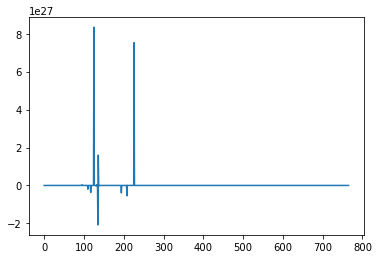

In [30]:
#Top eigenvalue

#plot top eigenvalue
plt.figure()
plt.plot(Emaxval)

#Remove outliers (Take all points within two standard deviations [95%])
emaxind = np.argsort(np.abs(Emaxval - np.median(Emaxval)))[:int(0.90*len(V))]

# Visualize Volume on original embedding
cax = scprep.plot.scatter2d(
    origsamp[Eigind][emaxind],
    c = Emaxval[Eigind][emaxind],
    title="Original Data colored by top eigenvalue",
    fontsize=12,
    xlabel="PHATE 1",
    ylabel="PHATE 2",
    figsize = (12,8),
    s = 100
)


IndexError: index 791 is out of bounds for axis 0 with size 766

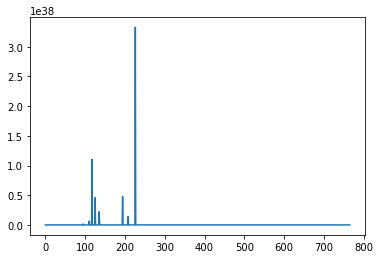

In [31]:
#Trace

#plot trace
plt.figure()
plt.plot(trace)

#Remove outliers (Take all points within two standard deviations [95%])
traceind = np.argsort(np.abs(trace - np.median(trace)))[:int(0.90*len(V))]

# Visualize Volume on original embedding
cax = scprep.plot.scatter2d(
    origsamp[Eigind[traceind]],
    c = trace[Eigind[traceind]],
    title="Original Data colored by trace",
    fontsize=12,
    xlabel="PHATE 1",
    ylabel="PHATE 2",
    figsize = (12,8),
    s = 100
)


In [ ]:
#Eigenvectors of FIM projection
    
valone = []
valtwo = []
for i in range(len(storeind)):
    valone.append(np.dot(tree_data[testind[storeind[i]],:],Emax[i]))
    valtwo.append(np.dot(tree_data[testind[storeind[i]],:],Emaxtwo[i]))
    
valone = np.array(valone)
valtwo = np.array(valtwo)


for i in :
    np.dot(origsamp[i,:],



In [ ]:
#Qudratic form of elementory vectors with FIM


